In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
seed = 1
import numpy as np
import random
np.random.seed(seed)
random.seed(seed)
import os 
import csv
import pickle
import time
import h5py
from collections import defaultdict
import tensorflow as tf
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy.ma as ma

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.2

In [6]:
from dataloader import load_data, DataLoader, DataLoader_time
from parser import get_parser
from utils import norm, normalize, is_normalized_matrix, extract_data, save_args, load_args, \
    save_embeddings, load_embeddings, DataStruct, save_model_tf, save_best_tf, load_model_tf, \
    save_emb_from_ckpt
from train import get_train_data, BestCriteria
from logger import Logger
from evaluation import Evaluator
from model import init_params, crossentropy, choose_emb, choose_geo_loss, STSkipgram
from multiprocess_tools import multiprocess_compute_distance

In [7]:
args = get_parser(['--CITY', 'NYC', '--LOG_DIR', 'log_test', '--normalize_weight', '--WITH_TIME', '--WITH_GPS', '--WITH_TIMESTAMP', 
                   '--geo_reg_type', 'l2'])

In [8]:
origin_data, dicts = load_data(os.path.join(args.ROOT, 'data','{}_INTV_processed_voc5_len2_setting_WITH_GPS_WITH_TIME_WITH_USERID.pk'.format(args.CITY) ))
args.vocabulary_size = dicts.vocabulary_size
data, idx = extract_data(origin_data, args)

loading data from /home/haibin2/data/checkins/data/NYC_INTV_processed_voc5_len2_setting_WITH_GPS_WITH_TIME_WITH_USERID.pk
args.pattern: hand
indices setting : normalize_weight WITH_TIMESTAMP WITH_TIME WITH_GPS
indices: [0, 2, 3, 4, 5]


In [9]:
train_data = get_train_data(data)

Mode:both, size:(162302, 2, 5) size:(162302, 2, 5) total size:(324604, 2, 5)


In [77]:
tf.losses.mean_squared_error?

In [80]:
def update(losses, sk, geo, t):
    assert type(losses) is dict, 'losses is expected to be dict'
    losses['geo'].append(geo)
    losses['skipgram'].append(sk)
    losses['time'].append(t)
    return losses

def compute_weight_decay(t1, t2, temp):
    return np.exp(-1*(abs(t1-t2)/60*temp))

def evaluate(emb, evaluator):
    result = evaluator.evaluate(emb)
    evaluator.update_history(res_dict=result)
    evaluator.save_history()
    return result

def train(graph, sess, model, args, evaluator_emb, evaluator_weight, logger, dataloader, dataloader_time):
    save_args(args)
    losses = {'geo':[], 'skipgram':[], 'time':[]}
    n_batch = 0
    n_epoch = 0
    tick0 = time.time()
    
    best_criteria = BestCriteria(['{}_f1_{}'.format(mode, k) for mode in ['sub', 'root'] for k in [1,5,10]])
    with graph.as_default():
        saver = tf.train.Saver(model.all_params)
        if args.resume:
            sess = load_model_tf(saver, args, sess)
            evaluator.load_history(args)
        else:
            logger.renew_log_file()
            sess.run(tf.global_variables_initializer())
        logger.log('\nStart training')
        
        while dataloader.get_epoch() < args.num_epoch:
            if args.normalize_weight:
                _ = sess.run([model.normalize_geo_emb_op, model.normalize_sem_emb_op,
                              model.normalize_geo_wht_op, model.normalize_sem_wht_op])

            epoch_tick = time.time()
            emb, weight = sess.run([model.sem_emb, model.sem_wht])
#             result_emb = evaluate(emb, evaluator_emb)
#             result_weight = evaluate(weight, evaluator_weight)
#             result = result_emb if args.main_emb == 'emb' else result_weight
#             save_model_tf(saver, sess, args)
#             if best_criteria.should_save(result):
#                 tmp = dict(result)
#                 tmp['epoch'] = n_epoch
#                 tmp['batch'] = n_batch
#                 save_best_tf(saver, sess, args, {'args':vars(args), 'result':tmp})
            #-- Optimization steps 
            while n_epoch >= dataloader.get_epoch():
                center, context = next(dataloader.dg)
                sk_loss, _, geo_loss, _, a = sess.run([model.weighted_skipgram_loss, model.train_skipgram, model.geo_loss, model.train_geo, model.cosine_sim],
                          {model.center_loc:center.ids, 
                           model.label_loc:context.ids.reshape(-1,1),
                           model.weight_decay: compute_weight_decay(center.timestmp, context.timestmp, args.time_temp),
                           model.coor_center:center.coors, 
                           model.coor_label:context.coors})

                print('sk_loss: {} weight_decay: {}'.format(sk_loss, np.sum(weight_decay)))
                loc, time_label = next(dataloader_time.dg)
                t_loss, _ = sess.run([model.time_loss, model.train_t],
                         {model.center_loc:loc, model.label_t:time_label})
                
                losses = update(losses, sk=sk_loss, geo=geo_loss, t=t_loss)
                
                if n_batch % 100 == 0:
                    losses = {k:np.mean(v) for k, v in losses.items()}
                    evaluator_emb.update_history(losses=losses)
                    evaluator_weight.update_history(losses=losses)
                    logstr = '[{}] LOSS '.format(n_batch) + "".join(['{} : {:.6f} '.format(k, v) for k, v in losses.items()])
                    losses = {'geo':[], 'skipgram':[], 'time':[]}
                    logger.log(logstr)
                    
                n_batch += 1
            #-----------------------
            n_epoch += 1
            logstr = '#'*50+'\n'
            logstr += 'Ecpoh {}, used time: {}, eval: {}'.format(n_epoch, time.time()-epoch_tick, result)
            logger.log(logstr)
    logger.log('FINISH, USED TIME:{}'.format(time.time()-tick0))
    return sess

In [79]:
args.geo_reg_type = 'xn'

In [70]:
# args.time_temp = 0.01
# args.geo_temp = 10
# args.main_emb = 'emb'
# args.regulation_weight = 10
# args.num_epoch = 30
# args.resume = False
# args.n_processes = 3
# args.batch_size = 256

In [255]:
sess.close()

In [23]:
args.time_temp = 1000
args.num_epoch = 1

In [81]:
# dataloader = DataLoader(train_data, args)
# dataloader_time = DataLoader_time(data, args, idx)
# evaluator_emb = Evaluator(args, dicts, mode='emb')
# evaluator_weight = Evaluator(args, dicts, mode='weight')
# logger = Logger(os.path.join(args.LOG_DIR, 'log_txt'))

graph = tf.Graph()
with graph.as_default():
    model = STSkipgram(args)
    sess = tf.Session(graph=graph, config=config)
sess = train(graph, sess, model, args, evaluator_emb, evaluator_weight, logger, dataloader, dataloader_time)

Saved args to benchmark/args.json

Start training
[68.77553  68.45454  69.07356  68.93322  69.129654 68.968155 69.659386
 69.255066 69.81753  69.125206 67.33688  68.89388  67.33589  68.883606
 69.26381  69.366005 67.33555  69.20838  68.945755 69.505516 69.13584
 69.70017  69.04113  69.17405  69.21467  69.14224  69.84952  68.78903
 69.285545 69.46316  68.997314 69.13815  69.8533   67.33547  69.73669
 69.12296  69.26909  69.61879  69.12519  69.29826  68.73037  69.6498
 69.31247  67.33446  69.15773  69.80148  68.93997  69.40432  67.45378
 69.40179  68.9335   69.34122  69.38738  69.01755  69.13279  69.284004
 69.69801  69.74647  69.4465   69.432495 67.33486  69.602    69.31567
 69.59169  69.441956 69.07506  69.483604 69.74004  69.09158  69.424194
 68.947914 69.26139  69.11695  69.084694 69.36467  69.47377  69.412704
 69.02726  67.33446  69.412636 69.58748  69.48951  69.2864   69.63712
 68.73439  67.337425 69.21439  69.29479  69.44097  68.9886   69.21481
 69.44306  67.35859  69.383316 69.48

AssertionError: 

In [11]:
def compute_weight_decay(t1, t2, temp):
    return np.exp(-1*(abs(t1-t2)/60)*temp)

In [14]:
center, context = next(dataloader.dg)

In [11]:
for i in range(100):
    center, context = next(dataloader.dg)
    a = compute_weight_decay(center.timestmp, context.timestmp, temp)
    x, y = np.nonzero(a)
    print()

In [83]:
def compute_geo_weight(x, y, temp):
    return np.exp(-1*norm(x-y)*temp)

In [84]:
x = center.coors; y = context.coors

In [41]:
np.mean(norm(x-y)), np.std(norm(x-y))

(0.03250825797907949, 0.05113728825119217)

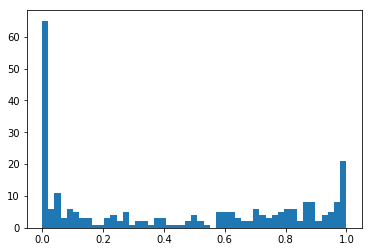

In [89]:
temp = 100
a = compute_geo_weight(center.coors, context.coors, temp)
_=plt.hist(a, bins=np.linspace(0,1,50))

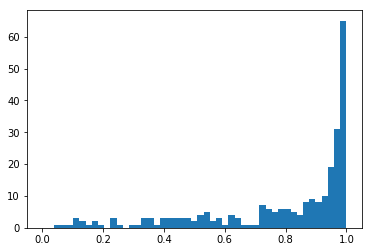

In [90]:
temp = 10
a = compute_geo_weight(center.coors, context.coors, temp)
_=plt.hist(a, bins=np.linspace(0,1,50))

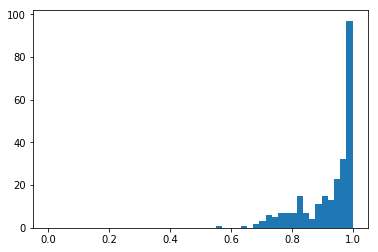

In [29]:
temp = 0.001
a = compute_weight_decay(center.timestmp, context.timestmp, temp)
_=plt.hist(a, bins=np.linspace(0,1,50))

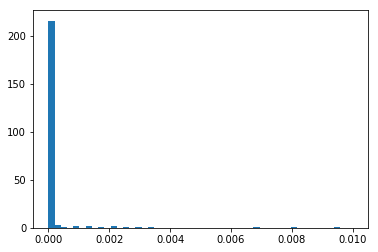

In [24]:
temp = 10
a = compute_weight_decay(center.timestmp, context.timestmp, temp)
_=plt.hist(a, bins=np.linspace(0,0.01,50))

---

In [57]:
args.LOG_DIR = 'benchmark'

In [60]:
save_emb_from_ckpt(args)

INFO:tensorflow:Restoring parameters from benchmark/best/model.ckpt
Saved data to benchmark/NYC_sem_emb.h5
Saved data to benchmark/NYC_embeddings.h5
Done, saved everything to benchmark, Used time 1.1390259265899658


In [54]:
tf.reset_default_graph()